In [5]:
!pip install transformers

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import random
import os

### SEED 고정

In [8]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [9]:
# 데이터 로드
save_path = "/content/"

train_df = pd.read_csv(save_path + 'train_preprocseeing_0210_2.csv')
train_df['synthetic'] = 'no'

test_df = pd.read_csv(save_path + 'test_preprocseeing_0210_3.csv')
submission_df = pd.read_csv(save_path + 'submission.csv')

## Augmentation

In [10]:
## Augmentation _KGv01
# 기존 파이프라인 톤을 유지하여 역번역 데이터를 로드. 다만,1,300개 동일 비율 실험을 위해 train_df에 바로 합치지 않고 주석 처리
#aug_rt_df = pd.read_csv(save_path + 'aug_rt_preprocseeing.csv')
#aug_rt_df['synthetic'] = 'back translation en'
#train_df = pd.concat([train_df, aug_rt_df], axis=0)

print(f"Augmentation 섹션 처리 완료. 현재 train_df 크기: {len(train_df)}")

Augmentation 섹션 처리 완료. 현재 train_df 크기: 3845


In [11]:
train_df

,class,conversation,synthetic
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...,no
1,협박 대화,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...,no
2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...,no
3,갈취 대화,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...,no
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,no
...,...,...,...
3840,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐? 내 머리가 뭐. 밥먹으면 대가리만 크냐 너는? ...,no
3841,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내 예.? ...,no
3842,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지. 왜 그래. 들리겠어....,no
3843,갈취 대화,누구맘대로 여기서 장사하래? 이게 무슨일입니까? 남의 구역에서 장사하려면 자릿세를 ...,no


## 일반대화 합성 데이터 셋

In [13]:
## 일반대화 합성 데이터 셋 _KGv01
# 1. Keywords with Persona 데이터 로드
general_k_p_df = pd.read_csv(save_path + 'general_k_p_preprocseeing.csv')
general_k_p_df['synthetic'] = 'keyword with persona'

# 2. Importance Keywords 데이터 로드
general_c_k_df = pd.read_csv(save_path + 'general_k_preprocseeing.csv')
general_c_k_df = general_c_k_df.sample(n=1500, random_state=seed)
general_c_k_df['synthetic'] = 'keyword'

# 3. Topic 데이터 로드 (업로드해주신 파일 적용) _KGv01
general_topic_df = pd.read_csv(save_path + 'general_c_t_preprocseeing.csv')
general_topic_df['synthetic'] = 'topic'

# 4. 전체 데이터 통합
train_df = pd.concat([train_df, general_k_p_df, general_c_k_df, general_topic_df], axis=0)

In [14]:
# 클래스 레이블 숫자 매핑
train_df.loc[train_df['class'] == '협박 대화', 'class'] = 0
train_df.loc[train_df['class'] == '갈취 대화', 'class'] = 1
train_df.loc[train_df['class'] == '직장 내 괴롭힘 대화', 'class'] = 2
train_df.loc[train_df['class'] == '기타 괴롭힘 대화', 'class'] = 3
train_df.loc[train_df['class'] == '일반 대화', 'class'] = 4

In [15]:
pd.set_option('display.unicode.east_asian_width', True)
print("[Class Distribution]")
print(train_df['class'].value_counts())

print("=" * 100)

# 데이터 예시
display(train_df.head(5))

[Class Distribution]
class
4    7776
3    1010
1     973
2     970
0     892
Name: count, dtype: int64


,class,conversation,synthetic
0,0,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...,no
1,0,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...,no
2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...,no
3,1,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...,no
4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,no


## 사전 학습된 모델 불러오기

In [16]:
# roberta
#from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification


#bert_model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=5)
#tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

# KR-ELECTRA
from transformers import ElectraModel, ElectraTokenizer, ElectraForSequenceClassification

kr_electra_model = ElectraForSequenceClassification.from_pretrained("snunlp/KR-ELECTRA-discriminator", num_labels=5)
tokenizer = ElectraTokenizer.from_pretrained("snunlp/KR-ELECTRA-discriminator")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

ElectraForSequenceClassification LOAD REPORT from: snunlp/KR-ELECTRA-discriminator
Key                                               | Status     | 
--------------------------------------------------+------------+-
discriminator_predictions.dense_prediction.weight | UNEXPECTED | 
electra.embeddings.position_ids                   | UNEXPECTED | 
discriminator_predictions.dense.bias              | UNEXPECTED | 
discriminator_predictions.dense.weight            | UNEXPECTED | 
discriminator_predictions.dense_prediction.bias   | UNEXPECTED | 
classifier.out_proj.weight                        | MISSING    | 
classifier.out_proj.bias                          | MISSING    | 
classifier.dense.bias                             | MISSING    | 
classifier.dense.weight                           | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from th

tokenizer_config.json:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

## Dataloader

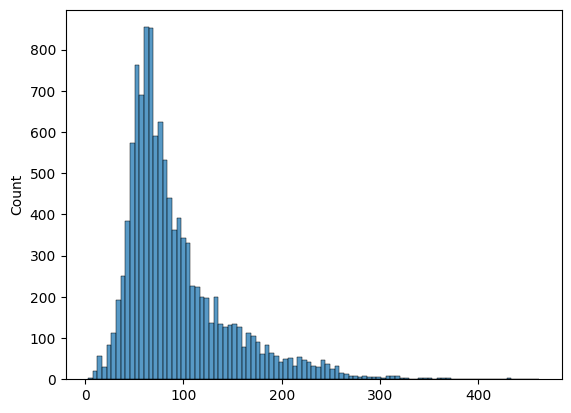

log value : 198.90456720344187


In [17]:
import seaborn as sns

tokenizer_len = [len(tokenizer(s)['input_ids']) for s in train_df['conversation']]
sns.histplot(tokenizer_len)
plt.show()

print(f'log value : {np.mean(tokenizer_len)+2*np.std(tokenizer_len)}')

In [18]:
a = 'none'
len(a)

4

In [19]:
# [KGv01_1,300개 추출]
# 각 클래스별 260개씩 뽑아 1,300개

n_per_class = 1300 // 5 # 260개
sampled_list = []

for c in range(5):
    # 각 클래스(0~4)에서 260개씩 랜덤 샘플링
    df_class = train_df[train_df['class'] == c].sample(n=n_per_class, random_state=42)
    sampled_list.append(df_class)

# 1,300개 데이터를 합치고 순서 섞어주기
train_df = pd.concat(sampled_list, axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"1,300개 추출")
print(train_df['class'].value_counts().sort_index())

1,300개 추출
class
0    260
1    260
2    260
3    260
4    260
Name: count, dtype: int64


In [20]:
class CleanTalkDataset(Dataset):
    def __init__(self, data, labels, is_trainable, synthetic_type, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.data = []
        self.labels = labels
        self.trainable = is_trainable
        self.synthetic_type = synthetic_type

        self.data = [tokenizer(text, padding='max_length', max_length=250, truncation=True, add_special_tokens=True, return_tensors='pt') for text in data.values]


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if len(self.synthetic_type) == len(self.data):
            syn_type = self.synthetic_type.values[idx]

        else:
            syn_type = torch.tensor([-1])

        if self.trainable:
            target = torch.tensor(self.labels.values[idx])
            return (sample, syn_type), target

        else:
            return (sample,syn_type), torch.tensor([-1])

In [21]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_val = train_test_split(train_df, test_size = 0.2, shuffle = True, random_state = 42, stratify=train_df['class'])

train_dataset = CleanTalkDataset(dataset_train['conversation'],dataset_train['class'],True,  dataset_train['synthetic'],tokenizer)
val_dataset = CleanTalkDataset(dataset_val['conversation'], dataset_val['class'], True, dataset_val['synthetic'], tokenizer)

for (text,syn_type), label in train_dataset:

    print(text)
    print(label)
    print(syn_type)

    break

{'input_ids': tensor([[    2,  3067, 17701,  3022,  5105,  5156,  3951, 29556,  5305,  3806,
          5103,  2994,  5309, 18868,  5036,     5,  3067,  5187,  3020, 13293,
         27956,    18,  9571,  2594,  3684, 23016,  8638,  5156,  8462,  5185,
          2402,  5216,  5036,  3742,  5590,  5033,  8346,  3959,  5188,  3790,
          5097,    35, 19623,  5208,  5185,  5071,  5199,  2923,  5033,  2634,
          5156,  8462,  5473,  4480,     5, 19623,  5048,  8374,  8824,  3915,
         24576, 25901,  3790,  8656, 10749, 11037, 13562,  5033,  9089,  5473,
         11674,  5871,  5185, 16297,  3443, 10519,  8474,  5294,  2437,  8590,
          5047, 11983,  5317,  3385,  3790,  5103,  2151,  2130,  5152,    35,
          8374, 11210,  5105,  5156,  5017,  5146,    35,  8386,  9531, 14870,
          5383,  4462,  5294,  2437,  2437,  5018,  8590,  2546, 11046, 27449,
          5017,  5146,    18, 11210,  5037,  5038, 10015,  5105,  5261,  5090,
             5,     3,     0,     0,  

In [22]:
import os
os.makedirs(save_path + 'data/', exist_ok=True)

dataset_train.to_csv(save_path + 'data/train_split_KGv01.csv', index=False)
dataset_val.to_csv(save_path + 'data/val_split_KGv01.csv', index=False)

dataset_val

,class,conversation,synthetic
238,3,지금 지나가는 저 사람 니 남친 뚱뚱한게 꼭 너랑 똑같은 돼지네. 그런 심한말을.!...,no
753,3,아직도 배달 안되었나요? 네? 저희 배달 완료했닥도 뜨는데요? 뭔소리에요 아직 마카...,no
969,3,야 너 오늘 옷 머냐 내옷???? 새로샀어 야 그몸뚱이에 그게 어울리냐 내몸이어때서...,no
1277,1,야 너 이리와봐 저요? 니 말고 또 누구 있냐? 오라면 와 왜 그러세요 야 가진 거...,no
436,2,최인턴 이 간식거리들 좀 탕비실에 정리해줄래요 ? 네. 알겠습니다. 주임님. 고마워...,no
...,...,...,...
136,2,막내씨 커피 좀. 근데 제가 꼭 커피 타야되나요? 어 당연하지. 막내잖아 나때는 더...,no
590,3,야 저기 도움반 애 온다 쟤 진짜 짜증나 저번에 계속 나쫓아다님 지능이 낮아서 그런...,no
665,0,입금받았으니 물건 빨리 보내시죠 당분간 바빠서 그래요 장난하십니까. 벌써 몇번째에요...,no
373,2,이대리님 저를 부르셨다구요 ? 박주임 혹시 지금 바빠요 ? 아닙니다! 무슨 일 있으...,no


In [23]:
train_dataloader = DataLoader(train_dataset,batch_size=64,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=64,shuffle=False)

for (text,syn_type), label in train_dataloader:
    print(text['input_ids'].size())
    print(text['attention_mask'].size())
    print(label.size())
    break

torch.Size([64, 1, 250])
torch.Size([64, 1, 250])
torch.Size([64])


## 모델 학습

In [24]:
from tqdm import tqdm
from transformers.optimization import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup

def model_train(model, train_dataloader, val_dataloader, learning_rate, epochs, patiece, model_nm):
    best_acc = 0
    early_stopping_threshold_count = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)  # cuda 또는 cpu 출력
    model.to(device)

    # class weight
    #numSample_list = [1000, 1000,1000,1000,5000]
    #class_weights = [1 - (x / sum(numSample_list)) for x in numSample_list]
    #class_weights = torch.FloatTensor(class_weights).to(device)

    criterion = nn.CrossEntropyLoss()
    #criterion = nn.CrossEntropyLoss(class_weights)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    t_total = len(train_dataloader) * epochs
    #scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(t_total * 0.1), num_training_steps=t_total)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(t_total * 0.1), num_training_steps=t_total)

    model = model.to(device)

    total_acc_train = []
    total_loss_train = []
    total_acc_val = []
    total_loss_val = []

    for epoch in range(epochs):

        train_loss_=0.0
        total = 0.0
        correct = 0.0

        model.train() # sets into the training mode

        for (train_input, syn_type), label in tqdm(train_dataloader):
            attention_mask = train_input['attention_mask'].squeeze(1).to(device)
            input_ids = train_input['input_ids'].squeeze(1).to(device)
            label = label.to(device)

            optimizer.zero_grad()

            output = model(input_ids, attention_mask) # from the forward function
            #print(output[0])
            loss = criterion(output.logits, label)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss_ += loss.item()

            preds = output[0].argmax(dim=-1)
            correct += (preds == label).sum().item()
            #correct += calc_accuracy(output[0], label)
            total += label.size(0)

        total_loss_train.append(train_loss_ / len(train_dataloader))
        total_acc_train.append(correct / total)

        print(f'Epochs: {epoch + 1} '
              f'| Train Loss: {total_loss_train[-1] : .3f} '
              f'| Train Accuracy: {total_acc_train[-1] : .3f} ')

        with torch.no_grad(): # since we should not change gradient for validation

            val_loss = 0.0
            val_total = 0.0
            val_correct = 0.0

            model.eval() # deactivate training

            # same process as the above
            for (val_input, syn_type), label in tqdm(val_dataloader):
                attention_mask = val_input['attention_mask'].squeeze(1).to(device)
                input_ids = val_input['input_ids'].squeeze(1).to(device)

                label = label.to(device)

                output = model(input_ids, attention_mask) # from the forward function

                loss = criterion(output.logits, label)
                val_loss += loss.item()

                preds = output[0].argmax(dim=-1)
                val_correct += (preds == label).sum().item()
                val_total += label.size(0)

        total_loss_val.append(val_loss / len(val_dataloader))
        total_acc_val.append(val_correct / val_total)

        print(
              f'| Val Loss: {total_loss_val[-1]: .3f} '
              f'| Val Accuracy: {total_acc_val[-1]: .3f}')

        if best_acc < total_acc_val[-1]:
            best_acc = total_acc_val[-1] # saving only the best one
            torch.save(model,f"{model_nm}.pt")
            print("Saved model")
            early_stopping_threshold_count = 0
        else:
            early_stopping_threshold_count += 1 # checking how many epochs have passed that val_loss didn't increase

        if early_stopping_threshold_count >= patience: # ==> patience=1
            print("Early stopping")
            break

    return total_loss_train, total_acc_train, total_loss_val, total_acc_val

In [25]:
model = kr_electra_model
model_nm = 'general_aug_rt_kr_electra_model_KG01' # 저장할 모델 이름
learning_rate = 0.00002
epochs = 10
patience = 5

total_loss_train, total_acc_train, total_loss_val, total_acc_val = model_train(model, train_dataloader, val_dataloader, learning_rate, epochs, patience, model_nm)

cuda


100%|██████████| 17/17 [00:40<00:00,  2.40s/it]


Epochs: 1 | Train Loss:  1.601 | Train Accuracy:  0.236 


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


| Val Loss:  1.543 | Val Accuracy:  0.569
Saved model


100%|██████████| 17/17 [00:42<00:00,  2.48s/it]


Epochs: 2 | Train Loss:  1.404 | Train Accuracy:  0.546 


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


| Val Loss:  1.198 | Val Accuracy:  0.727
Saved model


100%|██████████| 17/17 [00:41<00:00,  2.42s/it]


Epochs: 3 | Train Loss:  1.036 | Train Accuracy:  0.753 


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


| Val Loss:  0.844 | Val Accuracy:  0.808
Saved model


100%|██████████| 17/17 [00:41<00:00,  2.44s/it]


Epochs: 4 | Train Loss:  0.733 | Train Accuracy:  0.829 


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


| Val Loss:  0.606 | Val Accuracy:  0.877
Saved model


100%|██████████| 17/17 [00:41<00:00,  2.42s/it]


Epochs: 5 | Train Loss:  0.493 | Train Accuracy:  0.904 


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


| Val Loss:  0.476 | Val Accuracy:  0.908
Saved model


100%|██████████| 17/17 [00:41<00:00,  2.46s/it]


Epochs: 6 | Train Loss:  0.367 | Train Accuracy:  0.935 


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


| Val Loss:  0.411 | Val Accuracy:  0.896


100%|██████████| 17/17 [00:41<00:00,  2.41s/it]


Epochs: 7 | Train Loss:  0.263 | Train Accuracy:  0.960 


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


| Val Loss:  0.378 | Val Accuracy:  0.915
Saved model


100%|██████████| 17/17 [00:41<00:00,  2.45s/it]


Epochs: 8 | Train Loss:  0.212 | Train Accuracy:  0.979 


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


| Val Loss:  0.345 | Val Accuracy:  0.927
Saved model


100%|██████████| 17/17 [00:41<00:00,  2.43s/it]


Epochs: 9 | Train Loss:  0.168 | Train Accuracy:  0.988 


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


| Val Loss:  0.352 | Val Accuracy:  0.927


100%|██████████| 17/17 [00:41<00:00,  2.43s/it]


Epochs: 10 | Train Loss:  0.160 | Train Accuracy:  0.988 


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

| Val Loss:  0.354 | Val Accuracy:  0.923


## 모델 history 저장

In [26]:
import pickle

history = {'train_acc': total_acc_train}
history['train_loss'] = total_loss_train
history['val_acc'] = total_acc_val
history['val_loss'] = total_loss_val

# save data
file_name = f'{model_nm}_history.pickle'

with open('general_aug_rt_kr_electra_model_history.pickle','wb') as fw:
    pickle.dump(history, fw)

In [27]:
total_loss_val

[1.5433545351028441,
 1.1981664419174194,
 0.8442505836486817,
 0.6058754682540893,
 0.4758171021938324,
 0.41136087775230407,
 0.3783723920583725,
 0.34544811248779295,
 0.35186684131622314,
 0.3541223227977753]

## Validation Performance 분석

In [28]:


model.eval()
predict_list = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_list = ['협박 대화', '갈취 대화',  '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']
pred_list = []
label_list = []
syn_type_list = []
with torch.no_grad():
    for (val_input, syn_types), labels in val_dataloader:
        attention_mask = val_input['attention_mask'].squeeze(1).to(device)
        input_ids = val_input['input_ids'].squeeze(1).to(device)
        labels = labels.to(device)


        output = model(input_ids, attention_mask) # from the forward function
        preds = output[0].argmax(dim=-1)

        #MissClassification 확인
        for i in range(input_ids.size(0)):
            pred = preds[i].item()
            label = labels[i].item()
            syn_type = syn_types[i]
            pred_list.append(pred)
            label_list.append(label)
            syn_type_list.append(syn_type)
            decoded_sequence = tokenizer.decode(input_ids[i], skip_special_tokens=True,clean_up_tokenization_spaces=True)
            if label != pred:
                print('synthetic type: ', syn_type)
                print('오분류 text: ', decoded_sequence)
                print('==예측값 비교==')
                print(f'실제 라벨: {class_list[label]}, 예측된 라벨: {class_list[pred]}')
                print('='*100)



synthetic type:  no
오분류 text:  일주일 안에 100만원. 그걸 어떻게 모아! 못 구해오면 어쩔 수 없지. 뭘. 어떻게 장기를 팔든지 해야지. 미쳤어? 그러게 순순히 구해온다고 하면 되잖아. 넌 제정신이 아니야! 돈 앞에서 누가 제정신일 수 있겠니. 절대 못 구해와!
==예측값 비교==
실제 라벨: 갈취 대화, 예측된 라벨: 협박 대화
synthetic type:  no
오분류 text:  이번 일은 너가 책임좀 지어 줘야겠다. 작년에도 제가 맡고 경찰서도 갔다 오지 않았습니까. 그래서. 싫다는거야? 좀 힘들것 같습니다. 저도 사람답게 좀 살아보고 싶습니다. 그래도 죽는것보단 낫지 않겠어? 예.? 사장님 제가 잘하겠습니다. 니가 책임 져 주는 게 잘하는거야 이번 한 번만은 제발. 부탁한다 예.
==예측값 비교==
실제 라벨: 협박 대화, 예측된 라벨: 직장 내 괴롭힘 대화
synthetic type:  no
오분류 text:  얘 며늘아가. 이번 주 토요일 시간되지? 어머니 저 그날은 동창 모임이 있어요. 얘 넌 시어머니가 말씀하시는데 말대꾸니? 그게 아니라. 됐고! 내 친구들이랑 근교로 놀러가기로 했으니까 운전 좀 해라. 어머니 그 날은 어떻게 안될까요? 저도 간만에 보는 동창들인데. 너는 가정교육을 어떻게 받은거야? 시어머니가 말씀하시면 네네 하고 알아먹어야지!. 알겠습니다 어머니. 제가 모시고 갈게요. 그래. 처음부터 그러면 좀 좋니? 그리고 내 친구 두명 분 까지 도시락도 좀 준비해라. 네.??. 알겠습니다 어머님.
==예측값 비교==
실제 라벨: 기타 괴롭힘 대화, 예측된 라벨: 직장 내 괴롭힘 대화
synthetic type:  no
오분류 text:  야 니네집에 키위 농장한다며? 어 응 내가 키위 진짜 좋아하는데 좀 얻어먹어보자 응?? 우리도 다 파는건데 야 친구 좋다는게 뭐야 새끼야 그렇긴한데 나도 엄마아빠테 물어봐아햐고 그냥 니가 학교가서 먹는다고 가방에 몇개 넣어오면 되잖아. 우리엄마아빠가 힘들게 농사지으신건데 야 귀농

In [29]:
label_list

[3,
 3,
 3,
 1,
 2,
 1,
 1,
 0,
 1,
 4,
 4,
 2,
 1,
 3,
 3,
 2,
 3,
 4,
 2,
 0,
 2,
 3,
 0,
 0,
 0,
 4,
 1,
 0,
 0,
 3,
 0,
 1,
 0,
 3,
 2,
 1,
 2,
 3,
 0,
 4,
 0,
 2,
 2,
 1,
 3,
 4,
 4,
 1,
 3,
 3,
 1,
 0,
 0,
 3,
 4,
 0,
 0,
 1,
 0,
 4,
 0,
 1,
 4,
 1,
 2,
 4,
 3,
 2,
 2,
 4,
 0,
 1,
 0,
 4,
 4,
 0,
 1,
 2,
 1,
 4,
 4,
 4,
 2,
 4,
 2,
 4,
 1,
 3,
 3,
 0,
 2,
 2,
 1,
 1,
 2,
 4,
 4,
 1,
 2,
 0,
 3,
 0,
 0,
 1,
 4,
 0,
 1,
 4,
 3,
 3,
 3,
 1,
 0,
 2,
 0,
 1,
 0,
 1,
 1,
 3,
 2,
 1,
 2,
 0,
 0,
 2,
 4,
 1,
 3,
 4,
 4,
 2,
 4,
 0,
 1,
 2,
 4,
 3,
 1,
 0,
 2,
 4,
 1,
 2,
 4,
 3,
 1,
 1,
 3,
 3,
 4,
 2,
 2,
 3,
 3,
 2,
 2,
 3,
 3,
 2,
 4,
 3,
 1,
 0,
 1,
 3,
 0,
 0,
 0,
 3,
 2,
 1,
 4,
 4,
 4,
 3,
 1,
 0,
 0,
 1,
 3,
 2,
 3,
 4,
 0,
 3,
 1,
 3,
 0,
 0,
 4,
 1,
 1,
 1,
 2,
 3,
 4,
 3,
 0,
 4,
 3,
 2,
 4,
 4,
 3,
 1,
 1,
 3,
 3,
 0,
 1,
 2,
 1,
 2,
 2,
 4,
 2,
 0,
 3,
 0,
 3,
 0,
 3,
 4,
 4,
 3,
 1,
 2,
 4,
 4,
 1,
 2,
 4,
 4,
 0,
 2,
 1,
 2,
 1,
 0,
 4,
 0,
 4,
 0,
 4,
 2,
 2,
 4,
 2,
 0,


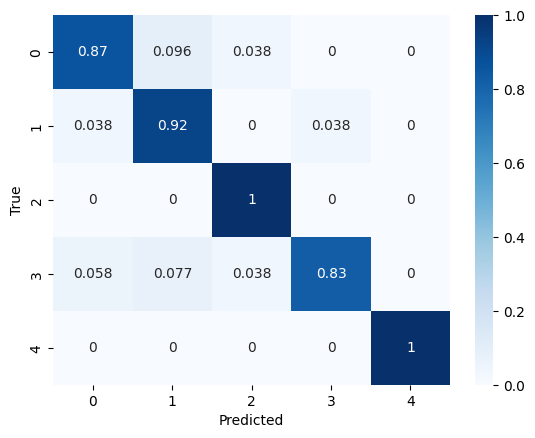

"\nfpr, tpr, thresholds = roc_curve(label_list, pred_list) \n\nplt.plot(fpr, tpr)\n\nplt.xlabel('FP Rate')\nplt.ylabel('TP Rate')\n\nplt.show()\n\nprint(roc_auc_score(label_list, pred_list))\n"

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label_list, pred_list, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
'''
fpr, tpr, thresholds = roc_curve(label_list, pred_list)

plt.plot(fpr, tpr)

plt.xlabel('FP Rate')
plt.ylabel('TP Rate')

plt.show()

print(roc_auc_score(label_list, pred_list))
'''

In [31]:
#class_list = ['협박 대화', '갈취 대화',  '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']
cm

array([[0.86538462, 0.09615385, 0.03846154, 0.        , 0.        ],
       [0.03846154, 0.92307692, 0.        , 0.03846154, 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.05769231, 0.07692308, 0.03846154, 0.82692308, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

## Test

In [32]:
test_dataset = CleanTalkDataset(test_df['conversation'],None, False, 'None', tokenizer)

test_dataloader = DataLoader(test_dataset,batch_size=64,shuffle=False)

for (text, syn_type), label in test_dataset:
    print(text['input_ids'].size())
    print(text['attention_mask'].size())

    break

torch.Size([1, 250])
torch.Size([1, 250])


## 저장한 모델 불러오기

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("general_aug_rt_kr_electra_model_KG01.pt", map_location=device, weights_only=False)
model.to(device)
model.eval()

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [34]:
model.eval()
predict_list = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for (test_input,syn_type), _ in test_dataloader:
        attention_mask = test_input['attention_mask'].squeeze(1).to(device)
        input_ids = test_input['input_ids'].squeeze(1).to(device)

        output = model(input_ids, attention_mask) # from the forward function
        preds = output[0].argmax(dim=-1)
        predict_list.append(preds)

predict_list = torch.cat(predict_list).cpu().detach().numpy()

## Submission 파일 생성

In [35]:
submission_df['class'] = predict_list
submission_df

,idx,class
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,3
4,t_004,3
...,...,...
495,t_495,2
496,t_496,2
497,t_497,1
498,t_498,2


In [41]:
submission_df.to_csv("/content/0212_KGv01_general_aug_rt_kr_electra_model_submission.csv", index=False)

### GPU 메모리 정리

In [40]:
import gc
gc.collect()
torch.cuda.empty_cache()